In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Code du TP

In [3]:
from qs import QS

In [4]:
class Waterfall:

    def __init__(self, lambda_a, lambda_t, lambda_d, nb_servers_test, nb_servers_front=1, q_test_size=None, q_front_size=None, size=100):

        rng = np.random.default_rng(seed=42)

        self.lambda_a = lambda_a
        self.lambda_t = lambda_t
        self.lambda_d = lambda_d

        self.nb_servers_test = nb_servers_test
        self.nb_servers_front = nb_servers_front

        self.a_dist = lambda size : rng.exponential(1./lambda_a, size=size)
        self.t_dist = lambda : rng.exponential(1./lambda_t)
        self.d_dist = lambda : rng.exponential(1./lambda_d)

        self.q_test_size = q_test_size
        self.q_front_size = q_front_size

        self.test_z = size

        self.q_test = QS(self.a_dist, self.t_dist, nb_servers_test, q_test_size, policy = lambda x: 0, test_size=size)
        self.q_front = QS(self.t_dist, self.d_dist, nb_servers_front, q_front_size, policy = lambda x: 0, test_size=size)

        pass

    def run(self):
        
        # Pretreat to generate arrivals
        self.q_test.pretreat()

        # Simule la file de tests
        self.q_test.run()

        # Transfert des départs du système de test comme arrivées pour le front
        valid_departures = self.q_test.tops[self.q_test.tops['t_depart_sys'] != -1]
        self.q_front.tops.loc[:, 't_arval_queue'] = valid_departures['t_depart_sys'].values

        # Simule la file de front
        self.q_front.run()

        pass

    def posttreat(self):
        """
        Calcule les statistiques pour les deux systèmes de files d'attente.
        """
        # Post-traitement des deux queues
        self.q_test.posttreat()
        self.q_front.posttreat()

        # Statistiques combinées
        combined_stats = {
            'Test Queue': self.q_test.timeline()[1],
            'Front Queue': self.q_front.timeline()[1]
        }

        return combined_stats
    

    def timeline(self, t_delation=2):
        """
        Retourne les processus et les statistiques pour chaque queue.
        """
        process_test, stats_test = self.q_test.timeline(t_delation)
        process_front, stats_front = self.q_front.timeline(t_delation)

        return {
            'Test Process': process_test,
            'Front Process': process_front,
            'Test Stats': stats_test,
            'Front Stats': stats_front
        }


In [5]:
# === Lambda parameters ===

tags_mean_dist = 5 # mean distance between incoming tags, in seconds
lambda_a = 1. / tags_mean_dist

k_test = 2 # number of servers in the test queue, i.e. number of tags that can be tested simultaneously
test_mean_dist = 10 # mean treatment time for a tag, in seconds (duration of the testsuite)
mu_t = 1. / test_mean_dist
lambda_t = mu_t * k_test

k_front = 1 # always 1 server
mu_d = 1. # mean time to transfer the result of a tag to the front of the user, in seconds
lambda_d = mu_d * k_front

# === Queue sizes === 
q_test_size = None # infinite
q_front_size = None # infinite

waterfall = Waterfall(
    lambda_a=lambda_a,
    lambda_t=lambda_t,
    lambda_d=lambda_d,
    nb_servers_test=k_test,
    nb_servers_front=k_front,
    q_test_size=q_front_size,
    q_front_size=q_front_size,
    size=100
)

In [6]:
waterfall.run()

waterfall_stats = waterfall.posttreat()

In [7]:
waterfall_stats

{'Test Queue':                    run value
 mean_sojourn_time   6.679029
 mean_waiting_time   1.636487
 mean_service_time   5.042542
 waiting_proportion      0.43
 blocked_proportion       0.0
 servers_max_usage   0.386935,
 'Front Queue':                    run value
 mean_sojourn_time   3.975519
 mean_waiting_time   3.028466
 mean_service_time   0.947053
 waiting_proportion      0.47
 blocked_proportion       0.0
 servers_max_usage   0.231156}

In [8]:
timeline = waterfall.timeline()

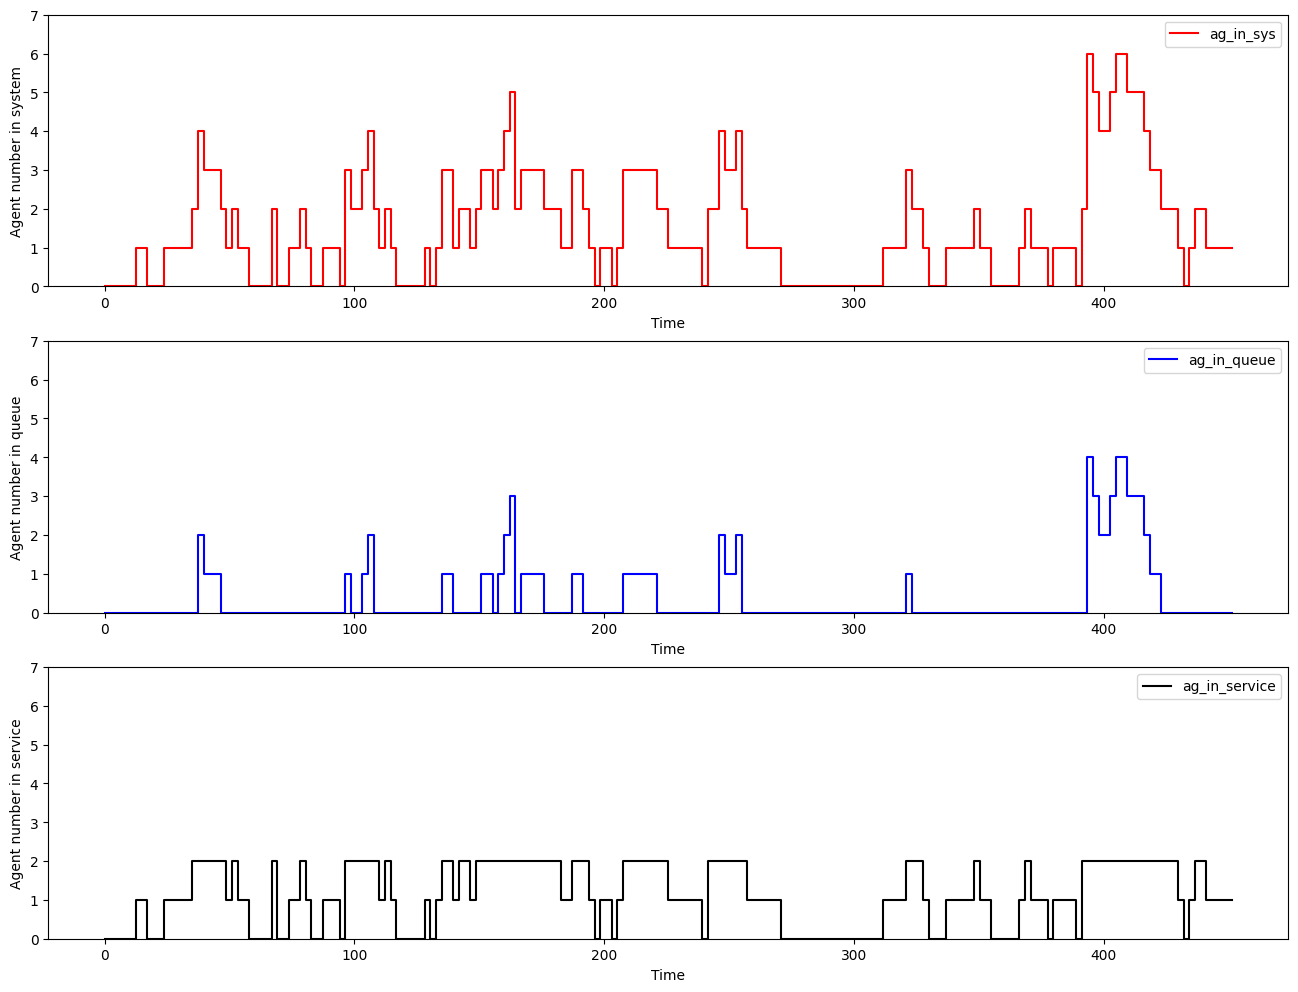

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Test Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Test Process']['ag_in_sys']+1)])

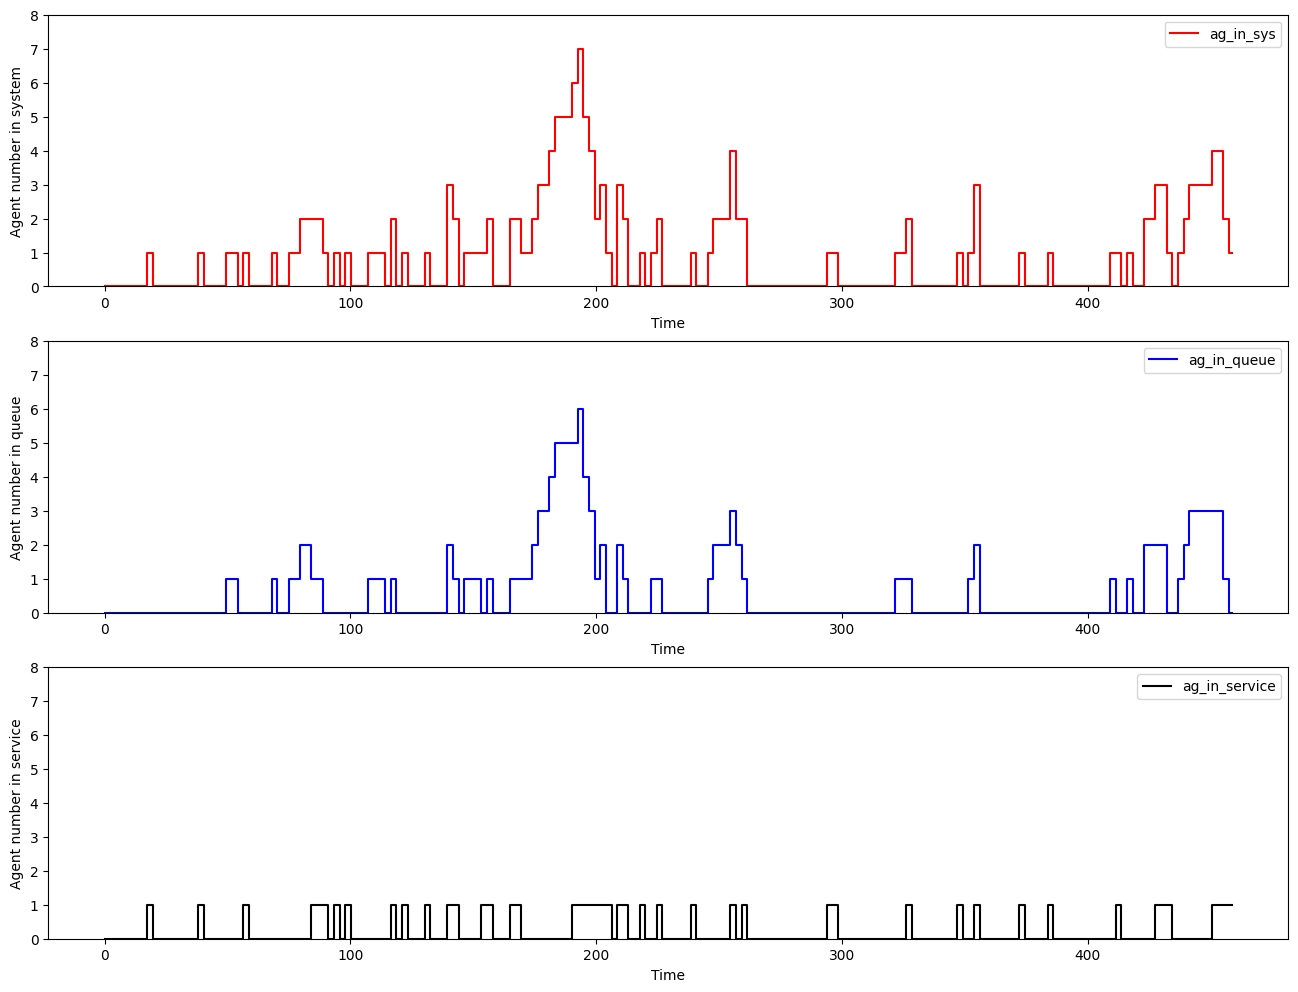

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Front Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Front Process']['ag_in_sys']+1)])

=========

In [35]:
# === Scenario 1 ===

# Une journée type sans rendu (9h-00h), avec unité de temps en minutes et lambda_a constant.

lambda_a = 16.67 # numver of tags per minute

k_test = 16 # number of servers in the test queue, i.e. number of tags that can be tested simultaneously
test_mean_dist = 1 # mean treatment time for a tag, in minutes (duration of the testsuite)
mu_t = 1. / test_mean_dist
lambda_t = mu_t * k_test

k_front = 1 # always 1 server
mu_d = 0.25 # mean time to transfer the result of a tag to the front of the user, in minutes
lambda_d = mu_d * k_front

# === Queue sizes === 
q_test_size = None # infinite
q_front_size = None # infinite

waterfall = Waterfall(
    lambda_a=lambda_a,
    lambda_t=lambda_t,
    lambda_d=lambda_d,
    nb_servers_test=k_test,
    nb_servers_front=k_front,
    q_test_size=q_front_size,
    q_front_size=q_front_size,
    size=15000 # total number of tags for scenario
)

In [30]:
waterfall.run()

waterfall_stats = waterfall.posttreat()

In [31]:
waterfall_stats

{'Test Queue':                    run value
 mean_sojourn_time   0.062693
 mean_waiting_time        0.0
 mean_service_time   0.062693
 waiting_proportion       0.0
 blocked_proportion       0.0
 servers_max_usage        0.0,
 'Front Queue':                        run value
 mean_sojourn_time   29658.273318
 mean_waiting_time    29654.25579
 mean_service_time       4.017528
 waiting_proportion      0.999867
 blocked_proportion           0.0
 servers_max_usage            1.0}

In [32]:
timeline = waterfall.timeline()

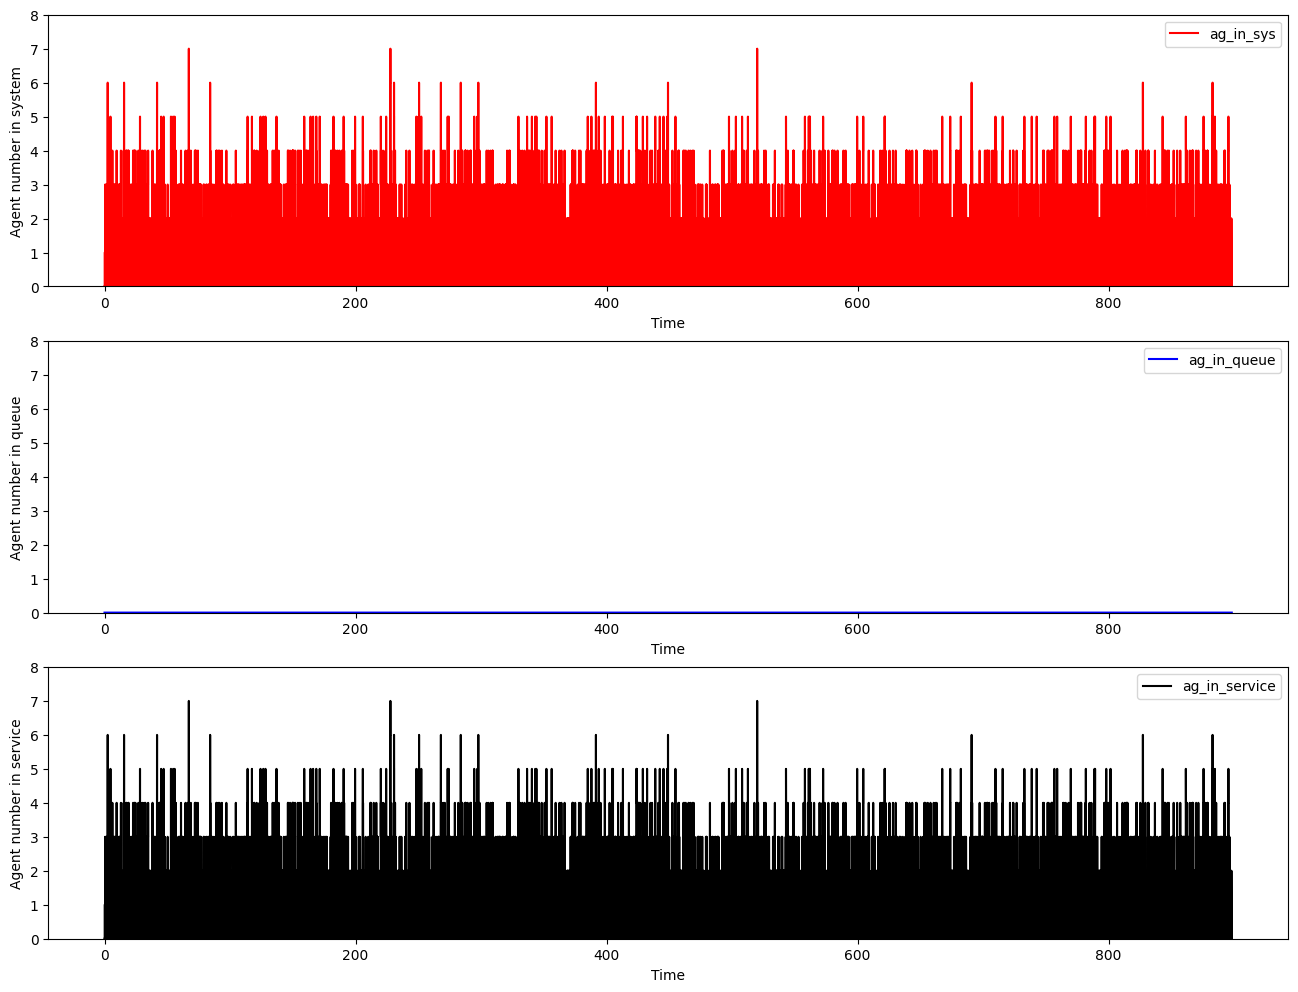

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Test Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Test Process']['ag_in_sys']+1)])

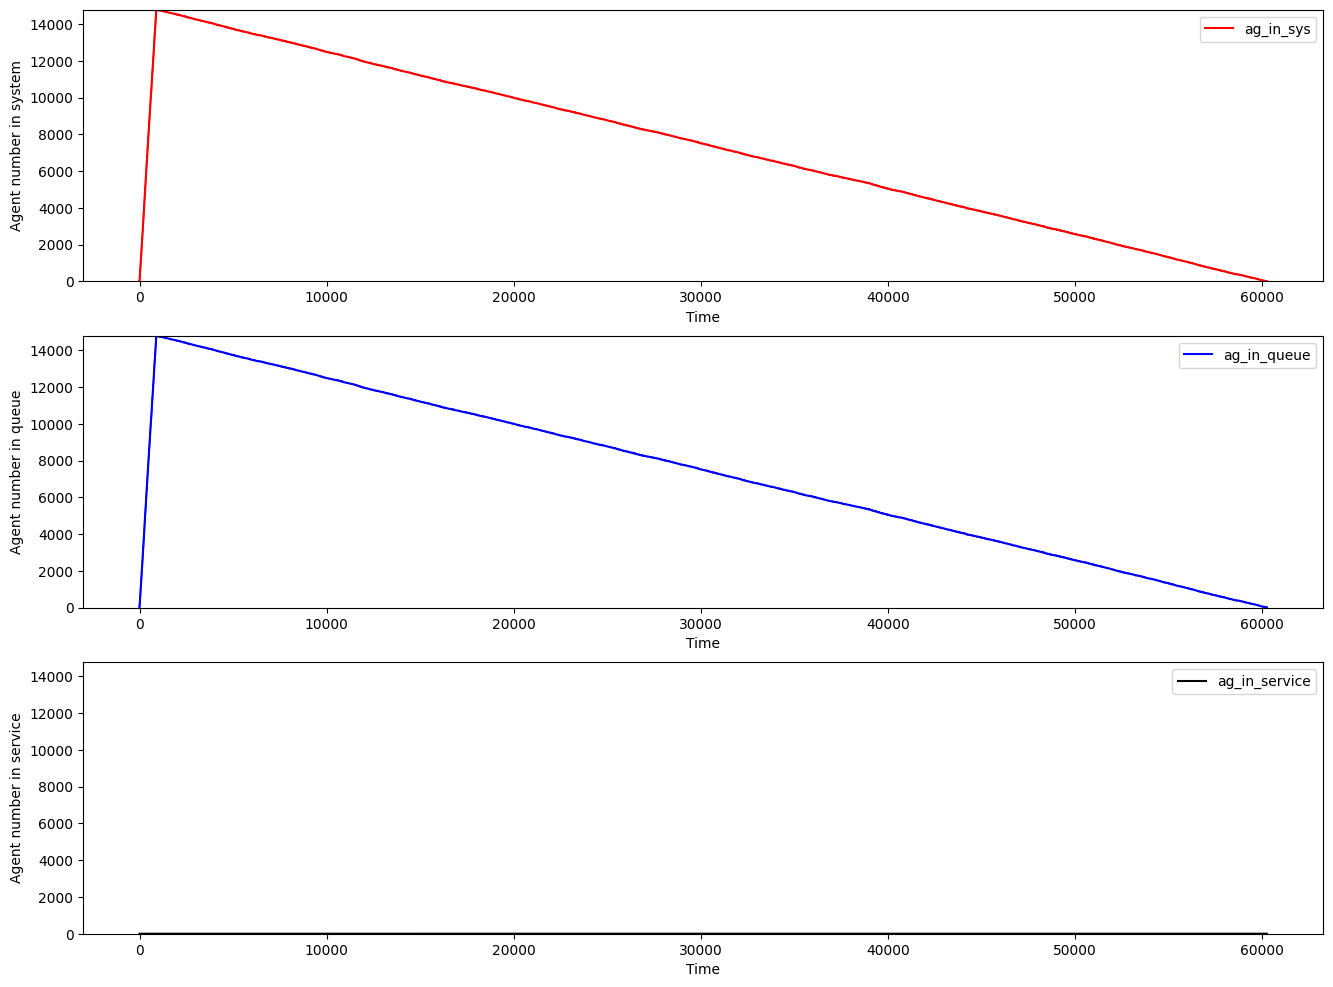

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    timeline['Front Process'].plot(y= counts[i], 
                   use_index=True, ax=axes[i], linewidth=1.5,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(timeline['Front Process']['ag_in_sys']+1)])